<a href="https://colab.research.google.com/github/GonzaloRomeroR/CEIA/blob/master/vision_computadora_2/clase_3/VPC2_clase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio: clase 3

Utilizando otro dataset, realizar transfer learning de otras arquitecturas disponibles y comparar resultados.

## Download dataset

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# Get kaggle json file
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [46]:
!kaggle datasets download -d alessiocorrado99/animals10 -p "./drive/My Drive/datasets/Animals-10"

 98% 575M/586M [00:06<00:00, 96.9MB/s]
100% 586M/586M [00:06<00:00, 91.5MB/s]


In [47]:
!kaggle datasets list -s Animals-10

ref                                                           title                                         size  lastUpdated          downloadCount  
------------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
alessiocorrado99/animals10                                    Animals-10                                   586MB  2019-12-12 20:46:33          19101  
agajorte/zoo-animals-extended-dataset                         Zoo Animals Extended Dataset                   2KB  2019-06-02 16:22:31           3064  
viratkothari/animal10                                         Animals-10                                   585MB  2020-09-17 18:56:19            443  
vishweshsalodkar/wild-animals                                  Wild Animals                                  7MB  2021-07-29 16:48:17            329  
hessahalkhattabi/animals                                      Animals                         

In [48]:
!kaggle datasets download -h

usage: kaggle datasets download [-h] [-f FILE_NAME] [-p PATH] [-w] [--unzip]
                                [-o] [-q]
                                [dataset]

optional arguments:
  -h, --help            show this help message and exit
  dataset               Dataset URL suffix in format <owner>/<dataset-name> (use "kaggle datasets list" to show options)
  -f FILE_NAME, --file FILE_NAME
                        File name, all files downloaded if not provided
                        (use "kaggle datasets files -d <dataset>" to show options)
  -p PATH, --path PATH  Folder where file(s) will be downloaded, defaults to current working directory
  -w, --wp              Download files to current working path
  --unzip               Unzip the downloaded file. Will delete the zip file when completed.
  -o, --force           Skip check whether local version of file is up to date, force file download
  -q, --quiet           Suppress printing information about the upload/download progress


In [6]:
import os
os.chdir('./drive/My Drive/datasets/Animals-10') 
!unzip -q animals10.zip -d animals10


replace animals10/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Load data

In [7]:
# Import libraries
import torch
from torch import nn
import pandas as pd
import time
import os
import copy
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
import torchvision.datasets as datasets
from torchvision import transforms, models
import torchvision
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler


In [8]:
# Load data
#os.chdir('./drive/My Drive/datasets/Animals-10') 
DIRECTORY = './animals10/raw-img/'
dataset = datasets.ImageFolder(DIRECTORY)


train_size = int(len(dataset) * 0.8)
val_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - val_size

train, val, test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

reduce = 0.1
train = Subset(train, np.arange(int(train_size * reduce)))
val = Subset(val, np.arange(int(val_size * reduce)))
test = Subset(test, np.arange(int(test_size * reduce)))


In [9]:
# Se definen las transformaciones para hacer data augmentation
torchvision_transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
# Se define el dataset
class CustomDataset(Dataset):
  def __init__(self, dataset, transform=None):
    super().__init__()
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    x = self.dataset[idx][0]
    if self.transform:
      x = self.transform(x)
    y = self.dataset[idx][1]
    return x, y
     

In [11]:
# Se definen los parámetros de entrenamiento
params = {'batch_size': 64,
          'shuffle': True,
          }

# Se generan los datasets y dataloaders
train_set = CustomDataset(train, torchvision_transform)
val_set = CustomDataset(val, torchvision_transform)
test_set = CustomDataset(test, torchvision_transform)

train_loader = torch.utils.data.DataLoader(train_set, **params)
val_loader = torch.utils.data.DataLoader(val_set, **params)
test_loader = torch.utils.data.DataLoader(test_set, **params)

In [12]:
len(val_set)

261

In [13]:
def idx_to_class(idx_dict, value):
  inv_dict = {v: k for k, v in idx_dict.items()}
  return inv_dict[value]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


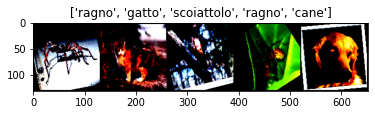

In [14]:
# Se imprimen algunas imágenes
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

num_images = 5

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:num_images])
imshow(out, title=[idx_to_class(dataset.class_to_idx, value.item()) for value in classes[:num_images]])

In [15]:
# Create model

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        for param in self.resnet18.parameters():
          param.requires_grad = False
        self.fc1 = nn.Linear(1000, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.resnet18(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [16]:
model = Net()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
def print_parameters(model):
  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in model.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(
      p.numel() for p in model.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')

### Resnet 50

In [18]:
res_50_model = models.resnet50(pretrained=True)

# freeze all layers in pretrained model
for name, param in res_50_model.named_parameters():
    param.requires_grad = False
    
# replace last layer 
res_50_model.fc = nn.Sequential(
    nn.Linear(res_50_model.fc.in_features, 500),
    nn.ReLU(),
    nn.Dropout(), 
    nn.Linear(500, 10)
)

dataloaders = {"train": train_loader, "val": val_loader,}
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res_50_model.parameters(), lr=0.0003, amsgrad=True)

print_parameters(res_50_model)
model = res_50_model

24,537,542 total parameters.
1,029,510 training parameters.


In [21]:
def fit(model, criterion, optimizer, dataloaders, epochs=50):
  # Se entrena el modelo
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(device)
  if torch.cuda.is_available():
    model.cuda()
  losses_train = []
  losses_val = []
  running_loss = 0.0
  for epoch in range(epochs):
      model.train()
      running_loss = 0.0
      correct = 0
      correct_val = 0
      model = model.train()
      for i, data in enumerate(dataloaders["train"]):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          _, preds = torch.max(outputs, 1)
          optimizer.step()
          running_loss += loss.item()
          correct += (preds == labels).float().sum()
      model = model.eval() 
      with torch.no_grad():
        valid_loss = 0.0
        for i, data in enumerate(dataloaders["val"]):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).float().sum()


      print('[%d] training loss: %.5f, validation loss: %.5f' %(epoch + 1, running_loss / len(train_loader), valid_loss / len(val_loader)), end="")
      print(", train accuracy {}, val accuracy {}".format(100 * correct / len(train_set), 100 * correct_val / len(val_set)))
      losses_train.append(running_loss / len(train_loader))
      losses_val.append(valid_loss / len(val_loader))
  return losses_train, losses_val

In [23]:
losses_train, losses_val = fit(res_50_model, criterion, optimizer, dataloaders)

cuda
[1] training loss: 0.67486, validation loss: 0.68571, train accuracy 78.7010498046875, val accuracy 78.54405975341797
[2] training loss: 0.63903, validation loss: 0.73681, train accuracy 77.88920593261719, val accuracy 78.16091918945312
[3] training loss: 0.62551, validation loss: 0.65999, train accuracy 79.75167083740234, val accuracy 80.84291076660156
[4] training loss: 0.60017, validation loss: 0.59862, train accuracy 80.56351470947266, val accuracy 81.9923324584961
[5] training loss: 0.57536, validation loss: 0.70658, train accuracy 80.99331665039062, val accuracy 80.45977020263672
[6] training loss: 0.57472, validation loss: 0.70358, train accuracy 80.37248992919922, val accuracy 77.77777862548828
[7] training loss: 0.57399, validation loss: 0.52918, train accuracy 81.42311096191406, val accuracy 81.9923324584961
[8] training loss: 0.55741, validation loss: 0.59051, train accuracy 81.18433380126953, val accuracy 79.31034088134766
[9] training loss: 0.52625, validation loss: 0

In [29]:
def plot_losses(losses, title="train"):
  # Se grafica el error de entrenamiento
  plt.plot(losses)
  plt.title(f"{title} loss")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.grid()

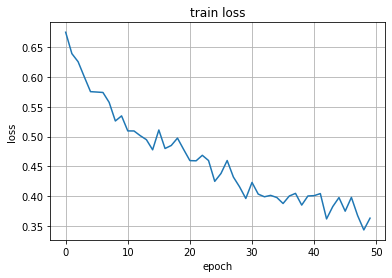

In [30]:
plot_losses(losses_train)

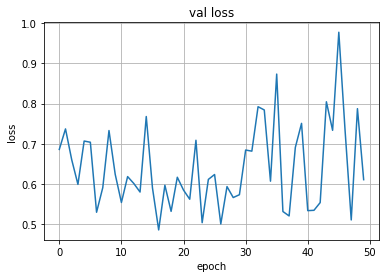

In [32]:
plot_losses(losses_val, title="val")


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network test images: {:.2f}'.format(correct / total))

Accuracy of the network test images: 0.84


In [34]:
classes = test.dataset.dataset.classes
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.2f}".format(classname, accuracy))

Accuracy for class cane  is: 68.18
Accuracy for class cavallo is: 74.07
Accuracy for class elefante is: 87.50
Accuracy for class farfalla is: 73.68
Accuracy for class gallina is: 87.18
Accuracy for class gatto is: 71.43
Accuracy for class mucca is: 78.95
Accuracy for class pecora is: 59.09
Accuracy for class ragno is: 98.04
Accuracy for class scoiattolo is: 70.00


### Google net

In [40]:
googlenet = models.googlenet(pretrained=True)

# freeze all layers in pretrained model
for name, param in googlenet.named_parameters():
    param.requires_grad = False
    
# replace last layer 
googlenet.fc = nn.Sequential(
    nn.Linear(googlenet.fc.in_features, 500),
    nn.ReLU(),
    nn.Dropout(), 
    nn.Linear(500, 10)
)

dataloaders = {"train": train_loader, "val": val_loader,}
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=0.0003, amsgrad=True)

print_parameters(googlenet)
model = googlenet

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

6,117,414 total parameters.
517,510 training parameters.


In [41]:
losses_train, losses_val = fit(googlenet, criterion, optimizer, dataloaders, epochs=10)

cuda
[1] training loss: 2.02834, validation loss: 1.73569, train accuracy 33.190067291259766, val accuracy 52.87356185913086
[2] training loss: 1.54606, validation loss: 1.47597, train accuracy 52.96084213256836, val accuracy 57.47126388549805
[3] training loss: 1.28195, validation loss: 1.31899, train accuracy 60.41069793701172, val accuracy 68.5823745727539
[4] training loss: 1.14847, validation loss: 1.17866, train accuracy 63.610313415527344, val accuracy 65.13410186767578
[5] training loss: 1.05728, validation loss: 0.99338, train accuracy 65.85482025146484, val accuracy 68.5823745727539
[6] training loss: 1.00450, validation loss: 0.95519, train accuracy 67.90830993652344, val accuracy 71.26436614990234
[7] training loss: 0.94203, validation loss: 0.91980, train accuracy 69.29322052001953, val accuracy 68.19923400878906
[8] training loss: 0.90023, validation loss: 0.94907, train accuracy 70.63037109375, val accuracy 70.49808502197266
[9] training loss: 0.94908, validation loss: 0

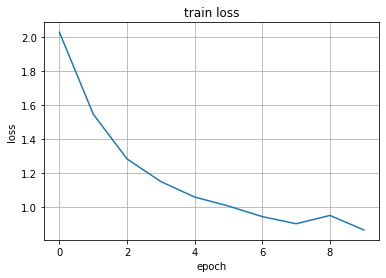

In [43]:
plot_losses(losses_train)

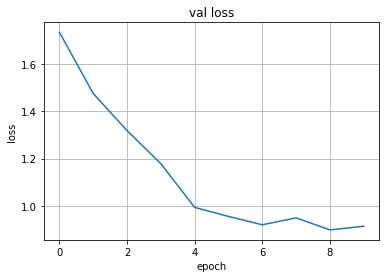

In [44]:
plot_losses(losses_val, title="val")


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network test images: {:.2f}'.format(correct / total))

Accuracy of the network test images: 0.72
